In [1]:
from pathlib import Path
import numpy as np
import tifffile
from skimage.exposure import match_histograms, rescale_intensity
from skimage.restoration import calibrate_denoiser, denoise_tv_chambolle
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import time



In [2]:
def optical_sectioning_sim(I1, I2, I3):
    os_image =np.sqrt(((I1-I2)**2)+((I2-I3)**2)+((I3-I1)**2))
    #os_image = 0.5 * np.sqrt((2*I2 - I1 - I3)**2 + (I3 - I1)**2)
    return os_image

def pWF_Recon(I1, I2, I3):
    pWF = (I1 + I2 + I3)/3
    return pWF

In [49]:
folder_Name = '072324'

#filename = 'n72_f90.tif'
filename = 'FULL_first90.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)

In [50]:
img = img.astype(np.float32)
os_sim = np.zeros((88, img.shape[1], img.shape[2]),dtype=np.uint16)
for i in range(1,87):
    os_sim[i-1] = optical_sectioning_sim(img[i-1,:,:], img[i,:,:], img[i+1,:,:])


In [51]:
#os_sim = rescale_intensity(os_sim,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_SIM_Reconstruction.tif', os_sim)


In [52]:
img = img.astype(np.float32)

os_sim2 = np.zeros((img.shape[1], img.shape[2]),dtype=np.float32)

os_sim2 = optical_sectioning_sim(img[1,:], img[2,:], img[3,:])
os_sim2 = rescale_intensity(os_sim2,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_NOmatchSIM_Reconstruction2.tif', os_sim2)

pWF2 = pWF_Recon(img[0,:,:], img[1,:,:], img[2,:,:])
pWF2 = rescale_intensity(pWF2,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_pWF_Reconstruction2.tif', pWF2)

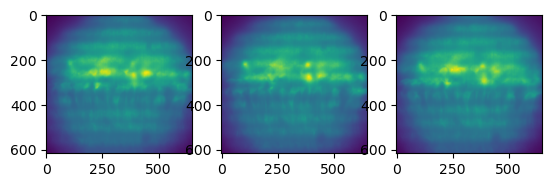

In [53]:
filename = 'simsim.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

sim_stack = np.zeros((90, img.shape[1], img.shape[2]),dtype=np.uint16)
sim_stack[0::3,:,:]=img[0,:,:]
sim_stack[1::3,:,:]=img[1,:,:]
sim_stack[2::3,:,:]=img[2,:,:]

plt.subplot(1,3,1)
plt.imshow(sim_stack[20,:,:])
plt.subplot(1,3,2)
plt.imshow(sim_stack[21,:,:])
plt.subplot(1,3,3)
plt.imshow(sim_stack[22,:,:])


for i in range(20,30):
    sim_stack[i,255:270,195:230] = sim_stack[i,255:270,195:230]+sim_stack[i,255:270,195:230]*(1/20)*(i-20)
    #sim_stack[i+1,255:270,195:230] = sim_stack[i+1,255:270,195:230]+0.1*(sim_stack[i+1,255:270,195:230]*(1/20)*(i-20))
    #sim_stack[i+2,255:270,195:230] = sim_stack[i+2,255:270,195:230]+0.15*(sim_stack[i+2,255:270,195:230]*(1/20)*(i-20))
for i in range(30,70):
    sim_stack[i,255:270,195:230] = sim_stack[i,255:270,195:230]+sim_stack[i,255:270,195:230]*(1/20)*(10)
    #sim_stack[i+1,255:270,195:230] = sim_stack[i+1,255:270,195:230]+0.1*(sim_stack[i+1,255:270,195:230]*(1/20)*(10))
    #sim_stack[i+2,255:270,195:230] = sim_stack[i+2,255:270,195:230]+0.15*(sim_stack[i+2,255:270,195:230]*(1/20)*(10))


os_sim = np.zeros((88, img.shape[1], img.shape[2]),dtype=np.float32)
pWF = np.zeros((88, img.shape[1], img.shape[2]),dtype=np.float32)

for i in range(1,87):
    os_sim[i-1] = optical_sectioning_sim(sim_stack[i-1,:,:]/8, sim_stack[i,:,:]/8, sim_stack[i+1,:,:]/8)
    pWF[i-1] = pWF_Recon(sim_stack[i-1,:,:], sim_stack[i,:,:], sim_stack[i+1,:,:])

sim_stack = rescale_intensity(sim_stack,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_try1.tif', sim_stack)

os_sim = rescale_intensity(os_sim,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_SIM_Reconstruction.tif', os_sim)

pWF = rescale_intensity(pWF,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_pWF_Reconstruction.tif', pWF)




Text(0, 0.5, 'Intensity')

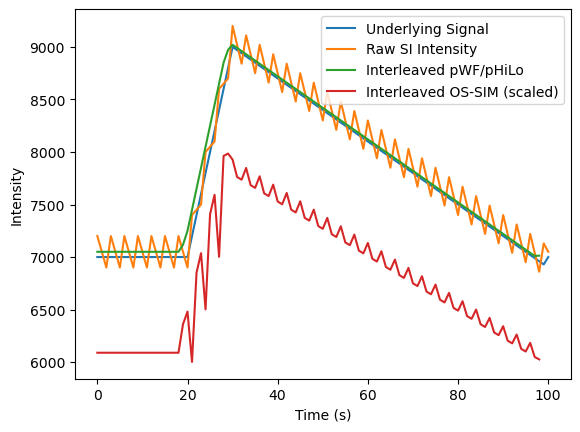

In [54]:
t = np.linspace(0, 100, 101)
f_cell = np.zeros(101)
for i in range(101):
    if i < 20:
        f_cell[i] = 7000
    elif 20<=i<30:
        f_cell[i] = 7000 + 200*(i-20)
    elif 30<=i<100:
        f_cell[i] = 9000 - 30*(i-30)
    else: 
        f_cell[i] = 7000


f_SIM = np.zeros(101)
f_SIM[0::3] = f_cell[0::3] + 200
f_SIM[1::3] = f_cell[1::3] + 50
f_SIM[2::3] = f_cell[2::3] - 100

f_WF = np.zeros(99)
f_OS = np.zeros(99)
for i in range(99):
    f_WF[i] = (f_SIM[i]+f_SIM[i+1]+f_SIM[i+2])/3
    f_OS[i] = np.sqrt(((f_SIM[i]-f_SIM[i+1])**2)+((f_SIM[i+1]-f_SIM[i+2])**2)+((f_SIM[i+2]-f_SIM[i])**2))


plt.plot(t, f_cell)
plt.plot(t, f_SIM)
plt.plot(t[0:99], f_WF)
plt.plot(t[0:99], (f_OS+5500)*f_cell[0:99]/np.max(f_OS+6000)) # SIM signal with scaling for modulation contrast and offset
plt.legend(['Underlying Signal', 'Raw SI Intensity', 'Interleaved pWF/pHiLo', 'Interleaved OS-SIM (scaled)'])
plt.xlabel('Time (s)')
plt.ylabel('Intensity')



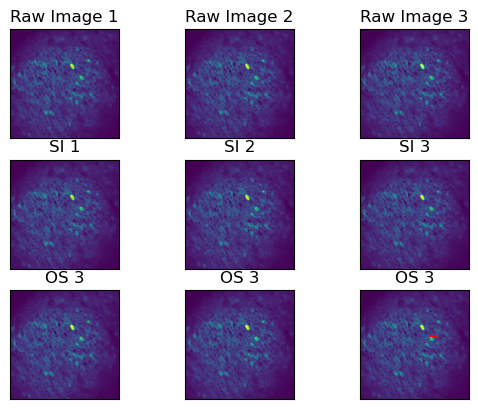

In [55]:
filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.05*np.sin(i/35*2*np.pi)+1

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.05*np.sin(i/35*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.05*np.sin(i/35*2*np.pi+4*np.pi/3)+1



#for i in range(0,img.shape[0]):
#    if i < 15:
#        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i)
#    elif 15<=i<30:
#        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(15)-img[i,125:145,190:210]*(1/20)*(i-15)


#si_stack[:,:,:] = img[:,:,:] 
si_stack = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]

#MM = rescale_intensity(si_stack,out_range=(0,65535)).astype(np.uint16)
#tifffile.imwrite(filename + '_SI_Mod.tif', MM)

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])



plt.subplot(3,3,1)
plt.imshow(img[20,:,:])
plt.title('Raw Image 1')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,2)
plt.imshow(img[21,:,:])
plt.title('Raw Image 2')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,3)
plt.imshow(img[22,:,:])
plt.title('Raw Image 3')
plt.xticks([])
plt.yticks([])



plt.subplot(3,3,4)
plt.imshow(si_stack[20,:,:])
plt.title('SI 1')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,5)
plt.imshow(si_stack[21,:,:])
plt.title('SI 2')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,6)
plt.imshow(si_stack[22,:,:])
plt.title('SI 3')
plt.xticks([])
plt.yticks([])


plt.subplot(3,3,7)
plt.imshow(OS_stack[20,:,:])
plt.title('OS 3')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,8)
plt.imshow(OS_stack[21,:,:])
plt.title('OS 3')
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,9)
plt.imshow(OS_stack[22,:,:])
plt.title('OS 3')
plt.xticks([])
plt.yticks([])

# add arrow showing the box that was modulated
plt.arrow(190,125,20,0, head_width=2, head_length=2, fc='r', ec='r')









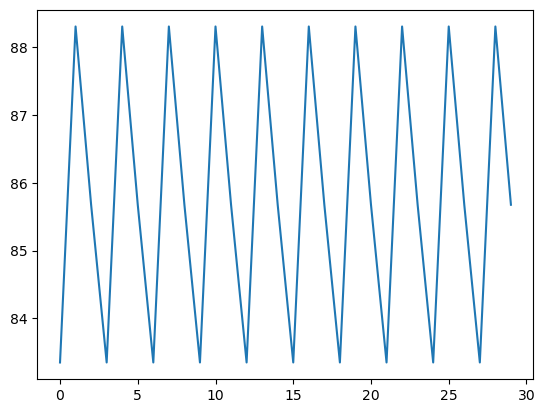

In [56]:
mean_stack = np.zeros(30,dtype=np.float32)
for i in range(30):
    mean_stack[i] = np.mean(si_stack[i,125:145,190:210])

    
plt.plot(mean_stack)

Text(0.5, 0, '# Frames')

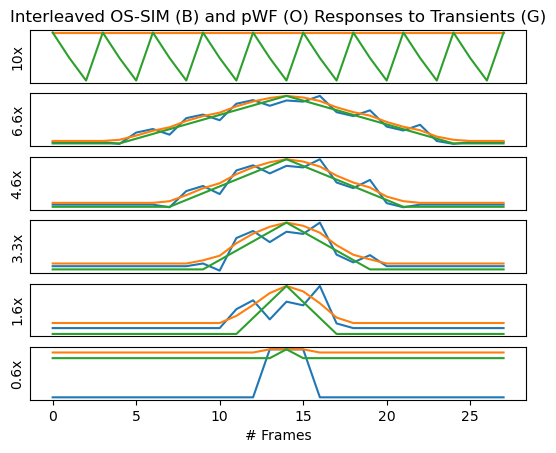

In [57]:

# plot the mean value for the box region in the center of the image for each frame in the OS reconstruction
mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,1)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])


## Subplot 2


filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+1

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+1


for i in range(10,img.shape[0]-10):
    if i < 15:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i-10)
    elif 15<=i<30:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(5)-img[i,125:145,190:210]*(1/20)*(i-15)

si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,4)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])

## Subplot 2


filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+1

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+1


for i in range(5,img.shape[0]-5):
    if i < 15:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i-5)
    elif 15<=i<30:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(10)-img[i,125:145,190:210]*(1/20)*(i-15)



si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,2)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])

## Subplot 4

filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+1

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+1


for i in range(12,img.shape[0]-12):
    if i < 15:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i-12)
    elif 15<=i<30:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(3)-img[i,125:145,190:210]*(1/20)*(i-15)



si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,5)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])


## Subplot 3

filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+1

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+1


for i in range(8,img.shape[0]-8):
    if i < 15:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i-8)
    elif 15<=i<30:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(7)-img[i,125:145,190:210]*(1/20)*(i-15)



si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,3)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])

## Subplot 6

filename = 'cy2p_30.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+20

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+20
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+20


for i in range(14,img.shape[0]-14):
    if i < 15:
        #img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(i-14)
        img[i,125:145,190:210] = img[i,125:145,190:210]+25*img[i,125:145,190:210]*(1/20)*(i-14)
    elif 15<=i<30:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/20)*(3)-img[i,125:145,190:210]*(1/20)*(i-15)



si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]



#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

MM = rescale_intensity(pWF_stack,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_WF6_Mod2.tif', MM)

OSS = rescale_intensity(OS_stack,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_OS6_Mod2.tif', OSS)

SII = rescale_intensity(si_stack,out_range=(0,65535)).astype(np.uint16)
tifffile.imwrite(filename + '_SII6_Mod2.tif', SII)

mean_OS = np.zeros(28)
mean_WF = np.zeros(28)
mean_img = np.zeros(28)
for i in range(28):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i+1,125:145,190:210])

plt.subplot(6,1,6)
plt.plot(mean_OS/max(mean_OS))
plt.plot(mean_WF/max(mean_WF))
plt.plot(mean_img/max(mean_img))
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])





plt.subplot(6,1,1)
plt.xticks([])
plt.yticks([])
plt.ylabel('10x')
plt.title('Interleaved OS-SIM (B) and pWF (O) Responses to Transients (G)')
#plt.legend(['Interleaved OS', 'Interleaved WF', 'Underlying Signal'])

plt.subplot(6,1,2)
plt.xticks([])
plt.yticks([])
plt.ylabel('6.6x')

plt.subplot(6,1,3)
plt.xticks([])
plt.yticks([])
plt.ylabel('4.6x')

plt.subplot(6,1,4)
plt.xticks([])
plt.yticks([])
plt.ylabel('3.3x')

plt.subplot(6,1,5)
plt.xticks([])
plt.yticks([])
plt.ylabel('1.6x')

plt.subplot(6,1,6)
#plt.xticks([])
plt.yticks([])
plt.ylabel('0.6x')
plt.xlabel('# Frames')

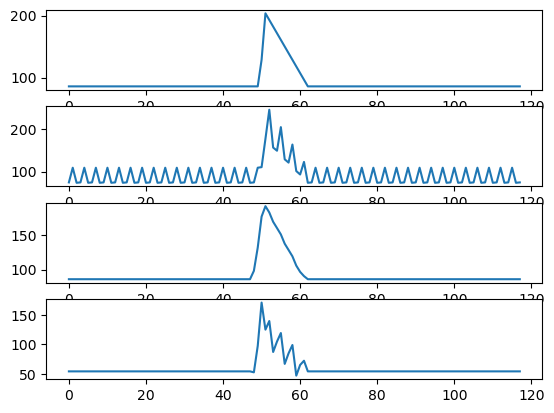

In [140]:
# Realistic Spike


filename = 'cy2p_120.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    #Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/35*2*np.pi)+1
    Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/70*2*np.pi)+1
    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.3*np.sin(i/70*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.3*np.sin(i/70*2*np.pi+4*np.pi/3)+1

mean_mod = np.zeros(3)
for i in range(3):
    mean_mod[i] = np.mean(Modulation[i,:,:])

#plt.plot(mean_mod)



for i in range(14,img.shape[0]-14):
    if 50<= i < 51:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/2)*(i-49)
        
    elif 51<=i<62:
        img[i,125:145,190:210] = img[i,125:145,190:210]+img[i,125:145,190:210]*(1/2)*(1/2)-img[i,125:145,190:210]*(1/8)*(i-60)



si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]



#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

MM = rescale_intensity(pWF_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_WFs_Mod1.tif', MM)

OSS = rescale_intensity(OS_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_OSs_Mod1.tif', OSS)

SII = rescale_intensity(si_stack[1:119,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_SIIs_Mod1.tif', SII)

IMG = rescale_intensity(img[1:119,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_IMGs_Mod1.tif', IMG)

mean_OS = np.zeros(120-2)
mean_WF = np.zeros(120-2)
mean_img = np.zeros(120-2)
mean_si = np.zeros(120-2)
for i in range(120-2):
    mean_OS[i] = np.mean(OS_stack[i,125:145,190:210])
    mean_WF[i] = np.mean(pWF_stack[i,125:145,190:210])
    mean_img[i] = np.mean(img[i,125:145,190:210])
    mean_si[i ] = np.mean(si_stack[i,125:145,190:210])

plt.subplot(4,1,1)
plt.plot(mean_img)
plt.subplot(4,1,2)
plt.plot(mean_si)
plt.subplot(4,1,3)
plt.plot(mean_WF)
plt.subplot(4,1,4)
plt.plot(mean_OS)


In [164]:
# Motion


filename = 'cy2p_120.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)

# add 20 pixels above, below, left and right of img for each frame in a new video
new_img = np.zeros((img.shape[0], 340, 340), dtype=np.float32)
for i in range(120):
    if i < 20:
        new_img[i,20:320,20:320] = img[i,:,:]
    elif 20<=i<40:
        xx = i 
        yy = i
        xf = 300 + i
        yf = 300 + i
        new_img[i,20:320,xx:xf,] = img[i,:,:]
    elif 40<=i<80:
        xx = 40-(i-40) 
        yy = 40-(i-40)
        xf = xx+300
        yf = yy+300
        new_img[i,20:320,xx:xf] = img[i,:,:]
    else:
        new_img[i,20:320,20:320] = img[i,:,:]







Modulation = np.ones((3, new_img.shape[1], new_img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    #Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/35*2*np.pi)+1
    Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/70*2*np.pi)+1
    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.3*np.sin(i/70*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.3*np.sin(i/70*2*np.pi+4*np.pi/3)+1

mean_mod = np.zeros(3)
for i in range(3):
    mean_mod[i] = np.mean(Modulation[i,:,:])

#plt.plot(mean_mod)






si_stack[:,:,:] = new_img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]



#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, new_img.shape[1], new_img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, new_img.shape[1], new_img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

MM = rescale_intensity(pWF_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_WF_LATmotion.tif', MM)

OSS = rescale_intensity(OS_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_OS_LATmotion.tif', OSS)

SII = rescale_intensity(si_stack[1:119,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_SIIs_LATmotion.tif', SII)

IMG = rescale_intensity(new_img[1:119,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_IMGs_LATmotion.tif', IMG)

In [22]:
filename1 = 'cy_09262023_grant.tif'
filename2 = 'cy_09262023_grant_30pGuas.tif'
filenames = [filename1, filename2]
img = np.zeros((2, 250, 300, 300), dtype=np.float32)
i = 0
for filename in filenames:
    input_file_path = Path(filename)
    root_path = input_file_path.parents[0]
    img[i,:,:,:] = tifffile.imread(input_file_path)
    img = img.astype(np.float32)
    i = i + 1



Modulation = np.ones((3, img.shape[2], img.shape[3]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    #Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/35*2*np.pi)+1
    Modulation[0,i,:] = Modulation[0,i,:]*0.3*np.sin(i/20*2*np.pi)+1
    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.3*np.sin(i/20*2*np.pi+2*np.pi/3)+1
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.3*np.sin(i/20*2*np.pi+4*np.pi/3)+1




in_stack = img[0,:,:,:] 
bg_stack = img[1,:,:,:]

ui_stack = in_stack[:,:,:]+10*bg_stack[:,:,:]

in_stack[0::3,:,:] = in_stack[0::3,:,:]*Modulation[0,:,:]
in_stack[1::3,:,:] = in_stack[1::3,:,:]*Modulation[1,:,:]
in_stack[2::3,:,:] = in_stack[2::3,:,:]*Modulation[2,:,:]

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[1]-2, img.shape[2], img.shape[3]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[1]-2, img.shape[2], img.shape[3]),dtype=np.float32)

si_stack = in_stack + 10*bg_stack

for i in range(1,img.shape[1]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack[i-1,:,:], si_stack[i,:,:], si_stack[i+1,:,:])

MM = rescale_intensity(pWF_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_WF50_BG.tif', MM)

OSS = rescale_intensity(OS_stack,out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_OS50_BG.tif', OSS)

SII = rescale_intensity(si_stack[1:249,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_SIIs50_BG.tif', SII)

IMG = rescale_intensity(ui_stack[1:249,:,:],out_range=(0,255)).astype(np.uint8)
tifffile.imwrite(filename + '_IMGs50_BG.tif', IMG)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [14]:
fps = 250/18
fps

13.88888888888889

In [51]:
# Noise Simulation 

filename = 'cy2p_270.tif'

input_file_path = Path(filename)
root_path = input_file_path.parents[0]
img = tifffile.imread(input_file_path)
img = img.astype(np.float32)
mm = np.mean(img)

Modulation = np.ones((3, img.shape[1], img.shape[2]),dtype=np.float32)

# apply a sin wave to the first modulation image with a period of 35 pixels and amplitude of 0.1
for i in range(0,img.shape[1]):
    Modulation[0,i,:] = Modulation[0,i,:]*0.5*np.sin(i/35*2*np.pi)+20

    # apply a sin wave to the second modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 120 degrees
    Modulation[1,i,:] = Modulation[1,i,:]*0.5*np.sin(i/35*2*np.pi+2*np.pi/3)+20
   
    # apply a sin wave to the third modulation image with a period of 35 pixels and amplitude of 0.1 that is phase shifted by 240 degrees
    Modulation[2,i,:] = Modulation[2,i,:]*0.5*np.sin(i/35*2*np.pi+4*np.pi/3)+20




si_stack[:,:,:] = img[:,:,:] 

si_stack[0::3,:,:] = si_stack[0::3,:,:]*Modulation[0,:,:]
si_stack[1::3,:,:] = si_stack[1::3,:,:]*Modulation[1,:,:]
si_stack[2::3,:,:] = si_stack[2::3,:,:]*Modulation[2,:,:]


# add poissson noise to the SI stack

PEAK = 1

si_stack_noisey = np.zeros((img.shape[0], img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(img.shape[0]):
    si_stack_noisey[i,:,:] = np.random.poisson(si_stack[i,:,:] / 255.0 * PEAK) / PEAK * 255

mm = np.mean(si_stack_noisey)
maxmax = np.max(si_stack_noisey)

#si_stack = si_stack 

OS_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
pWF_stack = np.zeros((img.shape[0]-2, img.shape[1], img.shape[2]),dtype=np.float32)
for i in range(1,img.shape[0]-1):
    OS_stack[i-1] = optical_sectioning_sim(si_stack_noisey[i-1,:,:], si_stack_noisey[i,:,:], si_stack_noisey[i+1,:,:])
    pWF_stack[i-1] = pWF_Recon(si_stack_noisey[i-1,:,:], si_stack_noisey[i,:,:], si_stack_noisey[i+1,:,:])

MM = rescale_intensity(pWF_stack,out_range=(0,65535)).astype(np.uint16)
#tifffile.imwrite(filename + '_WF_Noise10000.tif', MM)

OSS = rescale_intensity(OS_stack,out_range=(0,65535)).astype(np.uint16)
#tifffile.imwrite(filename + '_OS_Noise10000.tif', OSS)

SII = rescale_intensity(si_stack_noisey,out_range=(0,65535)).astype(np.uint16)
#tifffile.imwrite(filename + '_SI_Noise10000.tif', SII[1:269,:,:])















In [56]:
#mm
maxmax

10455.0

C:\Users\Fores\AppData\Local\Temp\ipykernel_30988\1908445065.py:20: RuntimeWarning: invalid value encountered in divide
  snr_img[i,:,:] = mean_img[i,:,:]/std_img[i,:,:]


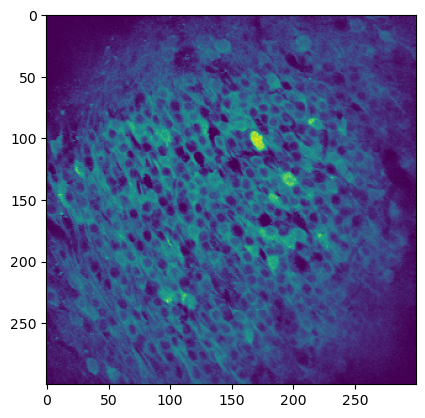

In [49]:
folder_Name = 'Noise_Test//HiLo'

# read in each .tif file in the folder 

mean_img = np.zeros((8,300,300))
std_img = np.zeros((8,300,300))
snr_img = np.zeros((8,300,300))

i = 0
for filename in os.listdir(folder_Name):
    if filename.endswith(".tif"):
        input_file_path = Path(folder_Name + '//' + filename)
        root_path = input_file_path.parents[0]
        img = tifffile.imread(input_file_path)
        img = img.astype(np.float32)

        # Create two images one for the mean of each pixel and one for the standard deviation of each pixel
        mean_img[i,:,:] = np.mean(img, axis=0)
        std_img[i,:,:] = np.std(img, axis=0)
        snr_img[i,:,:] = mean_img[i,:,:]/std_img[i,:,:]
        i = i + 1
       

plt.imshow(std_img[0,:,:])

mimin = np.min(std_img)


In [50]:
mimin

0.0